In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BCELoss, CrossEntropyLoss, MSELoss

from fastai.basics import set_seed
from fastrenewables.utils_pytorch import CATWrapper
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from pathlib import Path

plt.style.use('seaborn-colorblind')

#import glob

In [3]:
# export    
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100,  \
                 auxiliary=False, auxiliary_weighting_factor=0.1, label_bias=0, label_noise=0):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.real_loss = []
        self.fake_loss = []
        self.aux_loss = []
        self.auxiliary = auxiliary
        self.bce_loss = BCELoss()
        self.auxiliary_loss_function = CrossEntropyLoss()
        self.auxiliary_weighting_factor=auxiliary_weighting_factor
        self.label_bias = label_bias
        self.label_noise = label_noise
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.to_device(self.device)
        
    def noise(self, x):
        if len(x.shape) == 2:
            z = torch.randn(x.shape[0], self.n_z).to(self.device)
        elif len(x.shape) == 3:
            z = torch.randn(x.shape[0], self.n_z, x.shape[2]).to(self.device)
        else:
            raise NotImplementedError
        return z
    
    def to_device(self, device):
        self.device = device
        self.generator = self.generator.to(device)
        self.discriminator = self.discriminator.to(device)
        self.bce_loss = self.bce_loss.to(device)
        self.auxiliary_loss_function = self.auxiliary_loss_function.to(device)
        
    def _split_pred(self, y):
        if self.auxiliary:
            y, class_probs = y
        else:
            y, class_probs = y, None
        return y, class_probs
    
    def auxiliary_loss(self, class_probs, y):
        return self.auxiliary_loss_function(class_probs, y.long().squeeze())*self.auxiliary_weighting_factor
    
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(x_cat, x_cont_fake)  
        y_fake, class_probs = self._split_pred(y_fake)
        label = (1-self.label_bias)*torch.ones_like(y_fake) + self.label_noise*torch.randn(y_fake.shape).to(self.device)
        label = label.clamp(0, 1)
        loss = self.bce_loss(y_fake, label)
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            loss = (loss + aux_loss)
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(x_cat, x_cont)
        y_real, class_probs = self._split_pred(y_real)
        label = (1-self.label_bias)*torch.ones_like(y_real) + self.label_noise*torch.randn(y_real.shape).to(self.device)
        label = label.clamp(0, 1)
        real_loss = self.bce_loss(y_real, label)
        self.real_loss.append(real_loss.item())
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            self.aux_loss.append(aux_loss.item())
            real_loss = (real_loss + aux_loss)
        
        real_loss.backward()
        self.dis_optim.step()
        
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(x_cat, x_cont_fake)
        y_fake, class_probs = self._split_pred(y_fake)
        
        label = (0+self.label_bias)*torch.ones_like(y_fake) + self.label_noise*torch.randn(y_fake.shape).to(self.device)
        label = label.clamp(0, 1)
        fake_loss =  self.bce_loss(y_fake, label)
        self.fake_loss.append(fake_loss.item())
        if self.auxiliary:
            aux_loss = self.auxiliary_loss(class_probs, y)
            fake_loss = (fake_loss + aux_loss)
            
        fake_loss.backward()
        self.dis_optim.step()
        return
    
    def forward(self, x_cat, x_cont):
        z = self.noise(x_cont)
        x_gen = self.generator(x_cat, z)
        assert(x_gen.shape == x_cont.shape)
        y = self.discriminator(x_cat, x_gen)
        out = self._split_pred(y)
        return out

In [4]:
# export

class WGAN(GAN):
    def __init__(self, generator, discriminator, gen_optim, dis_optim, n_z=100, clip=0.01, auxiliary=False):
        super(WGAN, self).__init__(generator, discriminator, gen_optim, dis_optim, n_z, clip, auxiliary)
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optim = gen_optim
        self.dis_optim = dis_optim
        self.n_z = n_z
        self.clip = clip
        self.auxiliary = auxiliary
        self.real_loss = []
        self.fake_loss = []
        
    def train_generator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.generator.zero_grad()
        x_cont_fake = self.generator(x_cat, z)
        y_fake = self.discriminator(x_cat, x_cont_fake)
        loss = - y_fake.mean()
        loss.backward()
        self.gen_optim.step()
        return
    
    def train_discriminator(self, x_cat, x_cont, y):
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        y_real = self.discriminator(x_cat, x_cont)
        real_loss = - y_real.mean()
        real_loss.backward()
        self.dis_optim.step()
        self.real_loss.append(real_loss.item())
        
        z = self.noise(x_cont)
        self.discriminator.zero_grad()
        x_cont_fake = self.generator(x_cat, z).detach()
        y_fake = self.discriminator(x_cat, x_cont_fake)
        fake_loss = y_fake.mean()
        fake_loss.backward()
        self.dis_optim.step()
        self.fake_loss.append(fake_loss.item())
        
        for p in self.discriminator.parameters():
            p = torch.clamp(p, -self.clip, self.clip)
        return

In [5]:
# export
def get_gan_model(structure, n_classes=2, emb_module=None, bn=True, \
                  gan_type='bce', aux_factor=1, \
                  label_noise=0, label_bias=0,\
                  model_type = "MLP", len_ts=-1):
     
    if model_type.lower()=="mlp":
        len_ts = 1
    elif model_type.lower()=="tcn" and len_ts==-1 and gan_type.lower()=="aux":
        raise AttributeError("Please provide timeseries length.")

    structure = structure.copy()
    gen_structure = structure.copy()
    structure.reverse()
    dis_structure = structure
    dis_structure[-1] = 1
    n_z = gen_structure[0]
    
    if gan_type == 'bce' or gan_type == 'aux':
        final_act_dis = nn.Sigmoid
        opt_fct = torch.optim.Adam
        gan_class = GAN
    elif gan_type == 'wgan':
        final_act_dis = None
        opt_fct = torch.optim.RMSprop
        gan_class = WGAN
    
    if model_type.lower() == "mlp":
        generator = GANMLP(ann_structure=gen_structure, act_fct=nn.ReLU, final_act_fct=nn.Sigmoid, \
                       embedding_module=emb_module, bn_cont=bn)
    elif model_type.lower() == "tcn":
        generator = TemporalCNN(cnn_structure=gen_structure, \
                                            act_func=nn.ReLU,\
                                           cnn_type='tcn', 
                                           final_activation=nn.Sigmoid, \
                                           embedding_module=emb_module, 
                                           batch_norm_cont=bn, 
                                           add_embedding_at_layer=[idx for idx in range(len(gen_structure)-2)],
                       )
    else:
        raise ValueError
    
    if gan_type == 'aux':
        auxiliary = True
        dis_structure = dis_structure[:-1]
        final_input_size = dis_structure[-1]
        
        if model_type.lower() == "mlp":
            discriminator = GANMLP(ann_structure=dis_structure, 
                                   act_fct=nn.LeakyReLU, \
                                   final_act_fct=final_act_dis, \
                                   embedding_module=emb_module, 
                                   bn_cont=False)
        elif model_type.lower() == "tcn":
            discriminator = TemporalCNN(cnn_structure=dis_structure, \
                                            act_func=nn.LeakyReLU,\
                                           cnn_type='tcn', 
                                           final_activation=final_act_dis, \
                                           embedding_module=emb_module, 
                                           batch_norm_cont=False, 
                                           add_embedding_at_layer=[idx for idx in range(len(dis_structure)-2)],
                       )
        else:
            raise ValueError
                
        discriminator = AuxiliaryDiscriminator(basic_discriminator=discriminator, n_classes=n_classes, \
                                               final_input_size=final_input_size, len_ts=len_ts)  
    else:
        auxiliary = False
        if model_type.lower() == "mlp":
            discriminator = GANMLP(ann_structure=dis_structure, act_fct=nn.LeakyReLU, \
                               final_act_fct=final_act_dis, embedding_module=emb_module, bn_cont=False)
        elif model_type.lower() == "tcn":
            output_layer = nn.Sequential(
                nn.Linear(dis_structure[-2] * len_ts, 1), nn.Sigmoid()
            )
            output_layer = CATWrapper(output_layer)
            discriminator = TemporalCNN(
                cnn_structure=dis_structure[:-1],
                act_func=nn.LeakyReLU,
                cnn_type="tcn",
                final_activation=nn.LeakyReLU,
                embedding_module=emb_module,
                batch_norm_cont=False,
                input_sequence_length=len_ts,
                add_embedding_at_layer=[idx for idx in range(len(dis_structure) - 2)],
                sequence_transform=output_layer,
            )
        else:
            raise ValueError
        
    gen_opt = opt_fct(params=generator.parameters())
    dis_opt = opt_fct(params=discriminator.parameters())
    model = gan_class(generator=generator, discriminator=discriminator, gen_optim=gen_opt, dis_optim=dis_opt, n_z=n_z, \
                      auxiliary=auxiliary, auxiliary_weighting_factor=aux_factor, \
                      label_noise=label_noise, label_bias=label_bias)

    return model

In [6]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        with torch.no_grad():
            z = self.gan.noise(x_cont)
            fake_samples = self.gan.generator(x_cat, z)
        return fake_samples
    
    def fit(self, dl, epochs=10, lr=1e-3, plot_epochs=10, save_model=False, save_dir='models/', save_file='tmp', figsize=(16, 9)):
        
        self.gan.to_device(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self.gan.gen_optim.param_groups[0]['lr'] = lr
        self.gan.dis_optim.param_groups[0]['lr'] = lr
        
        self.gan.train()
        
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            #if (e+1)%plot_epochs==0:
                #plt.figure(figsize=figsize)
                #plt.plot(self.gan.real_loss, label='Real Loss')
                #plt.plot(self.gan.fake_loss, label='Fake Loss')
                #if len(self.gan.aux_loss) > 0:
                #    plt.plot(self.gan.aux_loss, label='Aux Loss')
                #plt.legend()
                #plt.show()
                
                #fig, ax1 = plt.subplots(figsize=figsize)
                #ax1.set_xlabel('iterations')
                #ax1.set_ylabel('bce loss')
                #ax1.plot(self.gan.real_loss, label='real', color='red')
                #ax1.plot(self.gan.fake_loss, label='fake', color='blue') 
                #ax1.tick_params(axis='y')
                #ax1.legend(loc='upper right')
                #
                #ax2 = ax1.twinx()
                #ax2.set_ylabel('aux loss')
                #ax2.plot(self.gan.aux_loss, label='aux', color='green')
                #ax2.tick_params(axis='y')
                #ax2.legend(loc='lower right')
                #
                #fig.tight_layout()
                #plt.show()
        
        self.gan.eval()
        
        if save_model:
            self.gan.to('cpu')
            Path(save_dir).mkdir(exist_ok=True, parents=True)

            torch.save(self.gan.to('cpu').state_dict(), save_dir+save_file+'.pt')
        
        return

### Examples:

In [7]:
# hide
n_samples = 2**12
n_classes = 4
n_features = 1
batch_size = 2**9
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 1
lr = 5e-5
n_gen = 1
n_dis = 1

data = GaussianDataset(n_samples, n_classes)
train_data, test_data = torch.utils.data.random_split(data, [int(len(data)*3/4), int(len(data)*1/4)])

train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, drop_last=True)

In [8]:
# export

def evaluate_gan(gan_type='bce', aux_factor=1, epochs=2):
    print(gan_type, aux_factor)
    set_seed(1337)
    emb_module = EmbeddingModule(categorical_dimensions=[n_classes+1])
    model = get_gan_model(structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb_module, gan_type=gan_type, aux_factor=aux_factor, label_noise=0.1, label_bias=0.25)
    learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
    learner.fit(train_dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)
    for x_cat, x_cont, y in test_dl:
        x_cat = x_cat.long()
        print('distribution of real data:')
        d_real = fit_kde(x_cont, bandwidth=1/25, show_plot=True)
        x_fake = learner.generate_samples(x_cat, x_cont)
        print('distribution of generated data:')
        d_fake = fit_kde(x_fake, bandwidth=1/25, show_plot=True)
        break
    kld = calculate_kld(d_real, d_fake)
        
    return kld

bce 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]


distribution of real data:


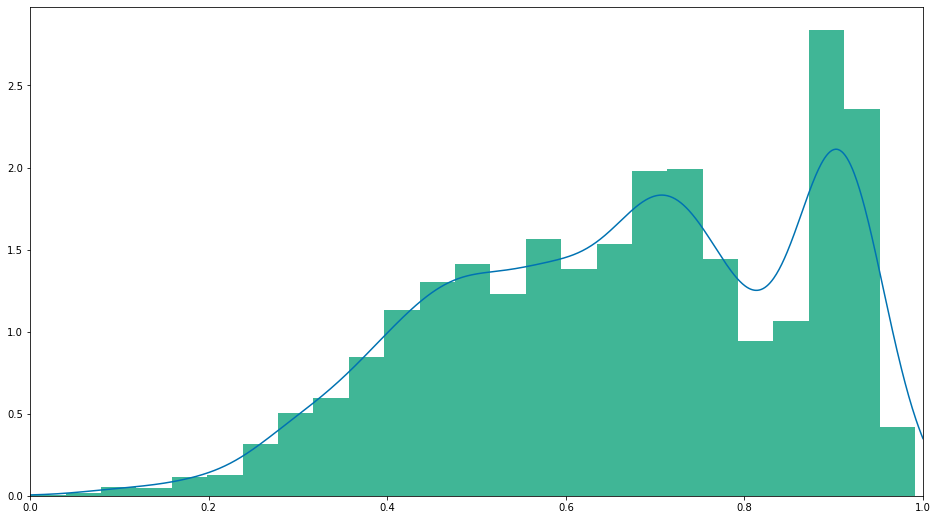

distribution of generated data:


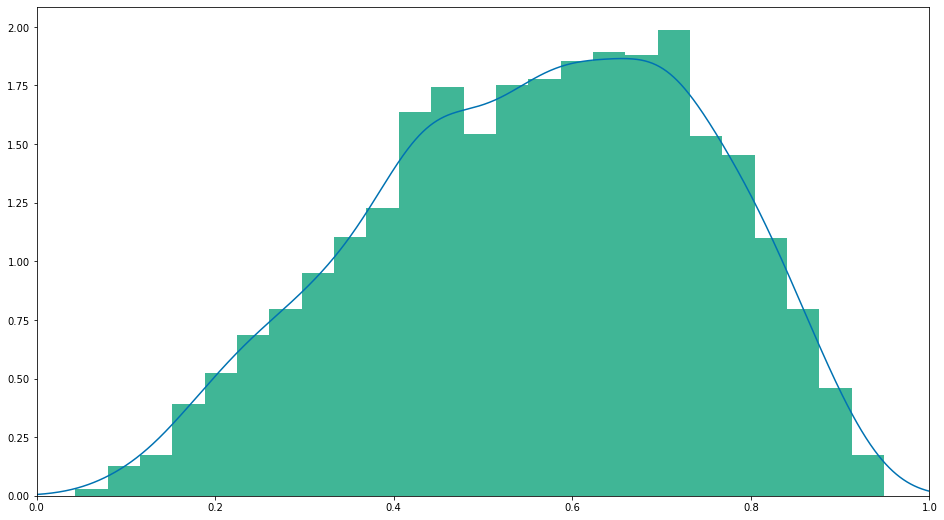

0.21448100490867938

In [9]:
# hide
evaluate_gan('bce')

aux 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]


distribution of real data:


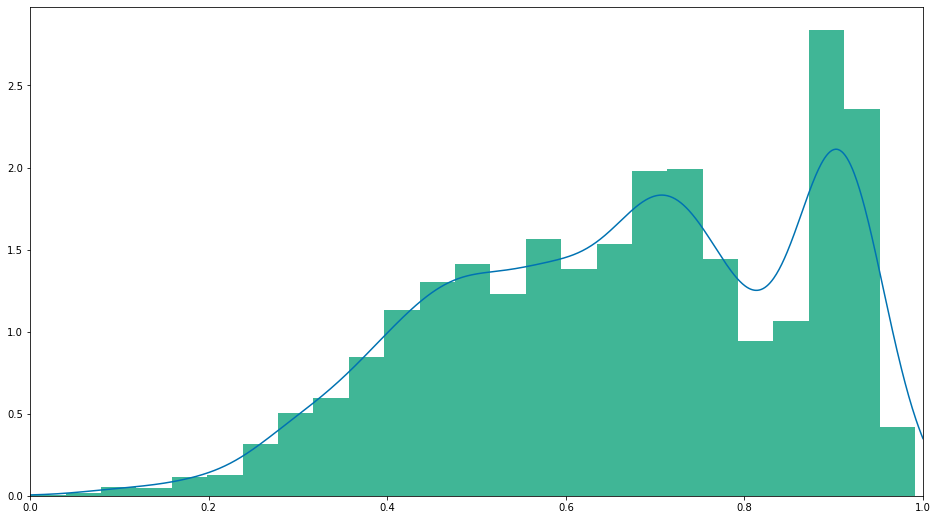

distribution of generated data:


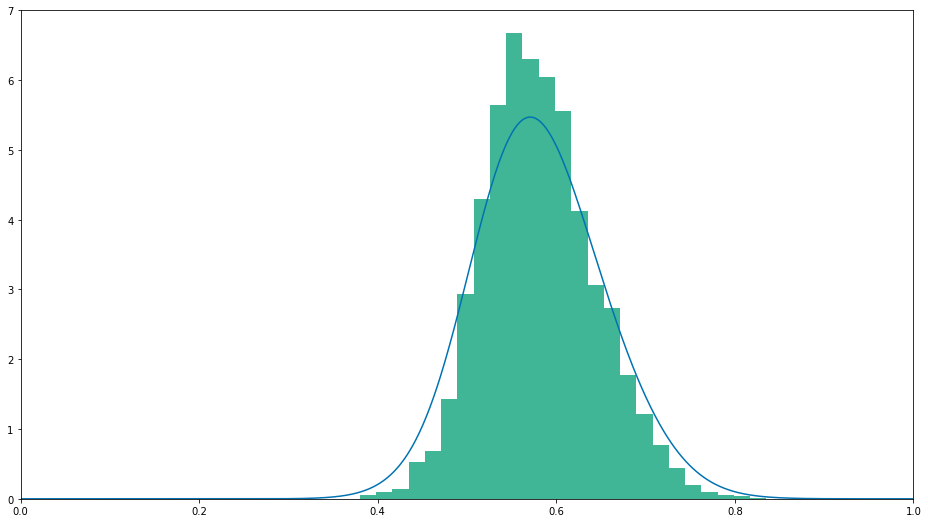

1.7636310946082454

In [10]:
# hide
evaluate_gan('aux')

In [11]:
#epochs = 100
#
#bce_kld = evaluate_gan('bce', 1, epochs)
#
#afs = [4, 2, 1, 1/2, 1/4]
#klds = [evaluate_gan('aux', af, epochs) for af in afs]
#
#afs.append(0)
#klds.append(bce_kld)
#
#data = {'aux_factor': afs,
#       'kld': klds}
#
#df = pd.DataFrame(data)
#df.to_csv('klds.csv', index=False)

In [12]:
#df = pd.read_csv('klds.csv')
#df
#
#afs = df['aux_factor'].values
#klds = df['kld'].values
#
#plt.figure(figsize=(16, 9))
#plt.plot(afs[:-1], klds[:-1], 'o--', label='auxiliary')
#plt.axhline(klds[-1], color='red', linestyle='--', label='conditional')
#plt.legend()
#plt.xscale('log',base=2) 
#plt.xticks(afs[:-1])
#plt.xlabel('auxiliary weighting factor')
#plt.ylabel('KLD')
#plt.show()